In [1]:
#import modules we need to use for this session
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

# Task 1. House price prediction using 311 data

### Can 311 complaining profile of urban neighborhoods enhance real-estate price prediction?

[Zhu, E., & Sobolevsky, S. (2018). House Price Modeling with Digital Census. arXiv preprint arXiv:1809.03834.]

Before we tried to use some parameters of the house (size) to predict its price. However notice that location matters as well. Below we upload a sample of more than 14000 individual house sales all around NYC in 2012. Each record together with the parameters of the house also contains important characteristics of the location (zip code) - average income of its residents (accodring to US census), as well as the relative structure of 311 complaints happening in the area.

In [2]:
folder=''

In [3]:
REsample=pd.read_csv(folder+'data/NYChome_sales2012.csv',index_col=0)

In [4]:
len(REsample)

14611

In [5]:
REsample.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
204018,4,LAURELTON,12941,94,NaN,A2,131-43 FRANCIS LEWIS BLVD,11413,0,3560,1473,1940,0,2012-01-01
217555,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217598,2,BAYCHESTER,4707,70,NaN,A5,1134 EAST 213 STREET,10469,0,2320,1813,1950,335700,2012-05-17
217599,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217600,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,10469,0,2759,1998,1945,0,2012-12-20


In [6]:
REsample.columns

Index(['borough', 'neighborhood', 'block', 'lot', 'easement',
       'building_class_present', 'address', 'zip_code', 'commmercial_units',
       'land_sq_feet', 'gross_sq_feet', 'year_built', 'sale_price',
       'sale_date'],
      dtype='object')

In [7]:
#how many houses do we have per each borough?
np.bincount(REsample.borough)

array([   0,  216,  894, 2769, 7288, 3444])

In [8]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(REsample))
REsample1=REsample.loc[splitind<=0.4]
REsample2=REsample.loc[(splitind>0.4)&(splitind<0.7)]
REsample3=REsample.loc[(splitind>=0.7)]

In [9]:
len(REsample1) #loosing around 50 records within sparse zip codes

5832

In [10]:
len(REsample2)

4394

In [11]:
len(REsample3)

4385

In [12]:
# now load and curate 311 data which we're going to use in order to characterize the location

In [13]:
data311 = pd.read_csv( folder+'data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [14]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')

In [15]:
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes

In [16]:
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)

In [17]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [18]:
list_311=list(data311.columns)

In [19]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

In [20]:
len(data311) #only 179 zip codes with reliable data left

179

In [21]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


#### Q1. Run linear regression 'sale_price ~ gross_sq_feet+land_sq_feet+year_built' over the training data

In [22]:
lm1 = smf.ols(formula = 'sale_price ~ gross_sq_feet + land_sq_feet + year_built', data = REsample1).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     342.8
Date:                Wed, 20 Nov 2019   Prob (F-statistic):          5.23e-205
Time:                        18:28:38   Log-Likelihood:                -88308.
No. Observations:                5832   AIC:                         1.766e+05
Df Residuals:                    5828   BIC:                         1.767e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      7.637e+06   8.92e+05      8.561      0.000    5.89e+06    9.39e+06
gross_sq_feet   429.2542     13.783     31.144      0.000     402.235     456.273
land_sq_feet    -33.5074      4.199     -7.979      0.000     -41.740     -25.275
year_built    -4081.0137    460.200     -8.868      0.000   -4983.177   -3178.851
==============================================================================
Omnibus:                    10546.282   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17222068.188
Skew:                          13.092   Prob(JB):                         0.00
Kurtosis:                     267.928   Cond. No.                     3.90e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Q2. Add 311 data corresponding to the zip code of the house location to REsample1,2,3 
in order to characterize the house's neighborhood by merging the dataframes REsample1,2,3 with data311 by zip code. Name merged dataframes REsample1_311, REsample2_311, REsample3_311 
rename 311 columns to F1,F2,... for easier formulae engineering
but keep the original names as a dictionary {'F1':'APPLIANCE', ...}

In [23]:
att = []
for i in range (1, 163):
    att.append('F{}'.format(i))
    i+=i
#print(att)

In [24]:
colname = []
for col in data311.columns:
    colname.append(col)
    
#print(colname)


In [25]:
dict311 = dict(zip(att, colname))
#print(dict311)

In [26]:
dict311reverse = dict(zip(colname, att))
#print(dict311reverse)

In [27]:
#dict311.keys()

In [28]:
data311 = data311.rename(columns = dict311reverse)
data311.head()

Complain,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


In [29]:
REsample11 = REsample1[['zip_code', 'sale_price', 'land_sq_feet', 'gross_sq_feet', 'year_built']]
REsample11.head()

,zip_code,sale_price,land_sq_feet,gross_sq_feet,year_built
217555,10457,345376,1964,1424,1899
217599,10469,338000,1710,1813,1945
217605,10469,250000,2514,1690,1950
217609,10469,249600,2283,1588,1910
217610,10469,313000,1710,1690,1945


In [30]:
REsample22 = REsample2[['zip_code', 'sale_price', 'land_sq_feet', 'gross_sq_feet', 'year_built']]
REsample22.head()

,zip_code,sale_price,land_sq_feet,gross_sq_feet,year_built
217600,10469,0,2759,1998,1945
217601,10469,0,2759,1998,1945
217603,10469,180000,1842,1744,1950
217612,10469,232000,1938,1974,1901
217614,10469,335000,1710,1890,1950


In [31]:
REsample33 = REsample3[['zip_code', 'sale_price', 'land_sq_feet', 'gross_sq_feet', 'year_built']]
REsample33.head()

,zip_code,sale_price,land_sq_feet,gross_sq_feet,year_built
204018,11413,0,3560,1473,1940
217598,10469,335700,2320,1813,1950
217602,10469,357500,1995,1701,1950
217604,10469,290000,2320,1690,1950
217606,10469,375000,4750,2399,1930


In [32]:
REsample1_311 = pd.merge(REsample11, data311, left_on = REsample1['zip_code'], right_index = True, how = 'inner')
REsample1_311.head()


,key_0,zip_code,sale_price,land_sq_feet,gross_sq_feet,year_built,F1,F2,F3,F4,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
217555,10457,10457,345376,1964,1424,1899,0.007921,0.0,0.001980,0.002087,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
220278,10457,10457,168324,3610,1998,1901,0.007921,0.0,0.001980,0.002087,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
220279,10457,10457,250000,2375,1617,1910,0.007921,0.0,0.001980,0.002087,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
220280,10457,10457,211000,2375,1825,1905,0.007921,0.0,0.001980,0.002087,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
217599,10469,10469,338000,1710,1813,1945,0.004757,0.0,0.001822,0.003643,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.046250,0.000101,0.0


In [33]:
REsample2_311 = pd.merge(REsample22, data311, left_on = REsample2['zip_code'], right_index = True, how = 'inner')
REsample2_311.head()

,key_0,zip_code,sale_price,land_sq_feet,gross_sq_feet,year_built,F1,F2,F3,F4,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
217600,10469,10469,0,2759,1998,1945,0.004757,0.0,0.001822,0.003643,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217601,10469,10469,0,2759,1998,1945,0.004757,0.0,0.001822,0.003643,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217603,10469,10469,180000,1842,1744,1950,0.004757,0.0,0.001822,0.003643,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217612,10469,10469,232000,1938,1974,1901,0.004757,0.0,0.001822,0.003643,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
217614,10469,10469,335000,1710,1890,1950,0.004757,0.0,0.001822,0.003643,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0


In [34]:
REsample3_311 = pd.merge(REsample33, data311, left_on = REsample3['zip_code'], right_index = True, how = 'inner')
REsample3_311.head()

,key_0,zip_code,sale_price,land_sq_feet,gross_sq_feet,year_built,F1,F2,F3,F4,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
204018,11413,11413,0,3560,1473,1940,0.001934,0.0,0.002462,0.0,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
286023,11413,11413,295074,4240,1231,1945,0.001934,0.0,0.002462,0.0,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
286025,11413,11413,0,3817,1094,1945,0.001934,0.0,0.002462,0.0,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
286026,11413,11413,0,5000,1148,1945,0.001934,0.0,0.002462,0.0,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
286027,11413,11413,336000,4720,1148,1945,0.001934,0.0,0.002462,0.0,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0


#### Q3. Run the linear model with 311
Train the model over the training sample REsample1_311 and test over the test sample REsample3_311,
report training and test R2

In [35]:
'+'.join(REsample1_311.columns[6:])

'F1+F2+F3+F4+F5+F6+F7+F8+F9+F10+F11+F12+F13+F14+F15+F16+F17+F18+F19+F20+F21+F22+F23+F24+F25+F26+F27+F28+F29+F30+F31+F32+F33+F34+F35+F36+F37+F38+F39+F40+F41+F42+F43+F44+F45+F46+F47+F48+F49+F50+F51+F52+F53+F54+F55+F56+F57+F58+F59+F60+F61+F62+F63+F64+F65+F66+F67+F68+F69+F70+F71+F72+F73+F74+F75+F76+F77+F78+F79+F80+F81+F82+F83+F84+F85+F86+F87+F88+F89+F90+F91+F92+F93+F94+F95+F96+F97+F98+F99+F100+F101+F102+F103+F104+F105+F106+F107+F108+F109+F110+F111+F112+F113+F114+F115+F116+F117+F118+F119+F120+F121+F122+F123+F124+F125+F126+F127+F128+F129+F130+F131+F132+F133+F134+F135+F136+F137+F138+F139+F140+F141+F142+F143+F144+F145+F146+F147+F148+F149+F150+F151+F152+F153+F154+F155+F156+F157+F158+F159+F160+F161+F162'

In [36]:
lm1_311 = smf.ols(formula = 'sale_price ~ gross_sq_feet + land_sq_feet + year_built +' + '+'.join(REsample1_311.columns[6:]), data = REsample1_311).fit()
lm1_311.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     30.23
Date:                Wed, 20 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:28:40   Log-Likelihood:                -85271.
No. Observations:                5710   AIC:                         1.708e+05
Df Residuals:                    5560   BIC:                         1.718e+05
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.873e+08    6.1e+07     -3.071      0.002   -3.07e+08   -6.77e+07
gross_sq_feet   160.0441     14.642     10.931      0.000     131.340     188.748
land_sq_feet      7.1463      4.080      1.751      0.080      -0.853      15.145
year_built      -48.2619    538.026     -0.090      0.929   -1103.003    1006.480
F1             1.711e+08   1.74e+08      0.982      0.326   -1.71e+08    5.13e+08
F2            -4.882e+09   1.92e+09     -2.545      0.011   -8.64e+09   -1.12e+09
F3             2.114e+08   1.27e+08      1.666      0.096   -3.74e+07     4.6e+08
F4             5.596e+08   2.19e+08      2.556      0.011     1.3e+08    9.89e+08
F5             -6.37e+07    1.3e+09     -0.049      0.961   -2.61e+09    2.48e+09
F6            -1.763e+08   1.18e+08     -1.489      0.137   -4.08e+08    5.58e+07
F7             3.628e+07   3.25e+08      0.112      0.911   -6.01e+08    6.73e+08
F8            -3.062e+08   4.36e+08     -0.703      0.482   -1.16e+09    5.48e+08
F9            -2.971e+09   8.72e+08     -3.406      0.001   -4.68e+09   -1.26e+09
F10            8.015e+08   1.11e+09      0.722      0.470   -1.37e+09    2.98e+09
F11           -2.458e+08   4.98e+08     -0.493      0.622   -1.22e+09    7.31e+08
F12            1.835e+08   6.03e+07      3.044      0.002    6.53e+07    3.02e+08
F13            6.783e+08   3.66e+08      1.853      0.064   -3.94e+07     1.4e+09
F14            2.666e+09   2.02e+09      1.317      0.188    -1.3e+09    6.63e+09
F15            2.736e+08    7.9e+08      0.346      0.729   -1.28e+09    1.82e+09
F16            2.075e+08   5.34e+07      3.884      0.000    1.03e+08    3.12e+08
F17            8.798e+08   8.32e+08      1.057      0.290   -7.51e+08    2.51e+09
F18            4.354e+09   2.71e+09      1.605      0.109   -9.65e+08    9.67e+09
F19            1.935e+08   6.12e+07      3.163      0.002    7.35e+07    3.13e+08
F20            2.458e+08   2.31e+08      1.063      0.288   -2.07e+08    6.99e+08
F21            3.304e+08   3.08e+08      1.071      0.284   -2.74e+08    9.35e+08
F22            8.023e+08   3.17e+09      0.253      0.800   -5.41e+09    7.01e+09
F23            1.709e+09   8.06e+08      2.121      0.034    1.29e+08    3.29e+09
F24           -6.473e+08   1.24e+09     -0.521      0.602   -3.08e+09    1.79e+09
F25            1.463e+08   6.73e+07      2.175      0.030    1.44e+07    2.78e+08
F26            2.024e+08   8.09e+07      2.501      0.012    4.37e+07    3.61e+08
F27           -1.356e+09   6.72e+08     -2.018      0.044   -2.67e+09   -3.88e+07
F28            1.988e+08   1.94e+08      1.023      0.306   -1.82e+08     5.8e+08
F29            6.696e+08   2.94e+08      2.278      0.023    9.33e+07    1.25e+09
F30            1.215e+09   8.42e+08      1.443      0.149   -4.36e+08    2.87e+09
F31            1.584e+08   5.51e+07      2.876   

In [37]:
from sklearn.metrics import r2_score

In [38]:
# In sample:
SalePricePred_IS=lm1_311.predict(REsample1_311.iloc[:,1:])
print("The IS R-squared of this is: {}".format(r2_score(REsample1_311.sale_price,SalePricePred_IS)))

The IS R-squared of this is: 0.44755585866664505


In [39]:
#Out of sample
SalePricePred_OS=lm1_311.predict(REsample3_311.iloc[:,1:])
print("The OS R-squared of this is: {0}".format(r2_score(REsample3_311.sale_price,SalePricePred_OS)))

The OS R-squared of this is: 0.2788057467391384


#### Q4. Apply regularization
Train Ridge and Lasso over REsample1_311 with an arbitrary default parameter $\alpha=1$.
Then evaluate their out-of-sample performance over REsample3_311
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [40]:
"','".join(REsample1_311.columns[6:])

"F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20','F21','F22','F23','F24','F25','F26','F27','F28','F29','F30','F31','F32','F33','F34','F35','F36','F37','F38','F39','F40','F41','F42','F43','F44','F45','F46','F47','F48','F49','F50','F51','F52','F53','F54','F55','F56','F57','F58','F59','F60','F61','F62','F63','F64','F65','F66','F67','F68','F69','F70','F71','F72','F73','F74','F75','F76','F77','F78','F79','F80','F81','F82','F83','F84','F85','F86','F87','F88','F89','F90','F91','F92','F93','F94','F95','F96','F97','F98','F99','F100','F101','F102','F103','F104','F105','F106','F107','F108','F109','F110','F111','F112','F113','F114','F115','F116','F117','F118','F119','F120','F121','F122','F123','F124','F125','F126','F127','F128','F129','F130','F131','F132','F133','F134','F135','F136','F137','F138','F139','F140','F141','F142','F143','F144','F145','F146','F147','F148','F149','F150','F151','F152','F153','F154','F155','F156','F157','F158','F

In [41]:
#REsample1_311.dtypes

In [42]:
REsample1_311['sale_price'].astype(float)
REsample1_311['gross_sq_feet'].astype(float)
REsample1_311['land_sq_feet'].astype(float)
REsample1_311['year_built'].astype(float)
REsample2_311['sale_price'].astype(float)
REsample2_311['gross_sq_feet'].astype(float)
REsample2_311['land_sq_feet'].astype(float)
REsample2_311['year_built'].astype(float)
REsample3_311['sale_price'].astype(float)
REsample3_311['gross_sq_feet'].astype(float)
REsample3_311['land_sq_feet'].astype(float)
REsample3_311['year_built'].astype(float)

204018    1940.0
286023    1945.0
286025    1945.0
286026    1945.0
286027    1945.0
286028    1945.0
286029    1950.0
286051    1945.0
286052    1945.0
286056    1930.0
286058    1945.0
286062    1950.0
286064    1950.0
286066    1935.0
286069    1930.0
286070    1930.0
286072    1930.0
286079    1950.0
286091    1930.0
286093    1950.0
286094    1920.0
286095    1920.0
286098    1920.0
286099    1945.0
286101    1935.0
286109    1935.0
286112    1940.0
286114    1940.0
286115    1940.0
286118    1940.0
           ...  
300651    1920.0
300652    1990.0
300657    1989.0
300659    1995.0
300667    1931.0
300676    1899.0
300682    1935.0
300684    1935.0
300687    1985.0
300689    1930.0
300692    1993.0
300693    1992.0
300696    1960.0
300697    1930.0
300698    1920.0
300701    1970.0
300702    1920.0
300706    1985.0
300709    1912.0
300710    1910.0
300712    1915.0
300719    1950.0
300725    1960.0
300726    1996.0
300727    1995.0
300728    1899.0
300729    1915.0
300730    2011

In [43]:
#REsample1_311.dtypes

In [44]:
#REsample1_311New = REsample1_311.drop(["sale_date", "easement"], axis=1)

In [45]:
#REsample2_311New = REsample2_311.drop(["sale_date", "easement"], axis=1)

In [46]:
#REsample3_311New = REsample3_311.drop(["sale_date", "easement"], axis=1)

In [47]:
#REsample1_311.iloc[:, 2:]

In [48]:
mu=REsample1_311.iloc[:,3:].mean()
sigma=REsample1_311.iloc[:,3:].std()

In [49]:
REsample1_311.iloc[:,3:]=(REsample1_311.iloc[:,3:]-mu)/sigma

In [50]:
REsample1_311.head()

,key_0,zip_code,sale_price,land_sq_feet,gross_sq_feet,year_built,F1,F2,F3,F4,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
217555,10457,10457,345376,-0.511639,-0.363210,-1.670001,3.536481,-0.33729,-0.349858,2.023700,...,-0.674430,0.239992,-0.993115,-0.453754,-0.174600,-0.719157,-1.423825,-0.937235,-0.278540,-0.208687
220278,10457,10457,168324,0.027231,0.250513,-1.593465,3.536481,-0.33729,-0.349858,2.023700,...,-0.674430,0.239992,-0.993115,-0.453754,-0.174600,-0.719157,-1.423825,-0.937235,-0.278540,-0.208687
220279,10457,10457,250000,-0.377085,-0.156854,-1.249051,3.536481,-0.33729,-0.349858,2.023700,...,-0.674430,0.239992,-0.993115,-0.453754,-0.174600,-0.719157,-1.423825,-0.937235,-0.278540,-0.208687
220280,10457,10457,211000,-0.377085,0.065541,-1.440392,3.536481,-0.33729,-0.349858,2.023700,...,-0.674430,0.239992,-0.993115,-0.453754,-0.174600,-0.719157,-1.423825,-0.937235,-0.278540,-0.208687
217599,10469,10469,338000,-0.594794,0.052710,0.090336,1.569431,-0.33729,-0.401531,3.711176,...,-0.071128,-0.041559,-0.559790,-0.589710,-0.453153,-0.082645,-0.750009,-0.155079,1.146794,-0.208687


In [51]:
REsample2_311.iloc[:,3:]=(REsample2_311.iloc[:,3:]-mu)/sigma

In [52]:
REsample2_311.head()

,key_0,zip_code,sale_price,land_sq_feet,gross_sq_feet,year_built,F1,F2,F3,F4,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
217600,10469,10469,0,-0.251370,0.250513,0.090336,1.569431,-0.33729,-0.401531,3.711176,...,-0.071128,-0.041559,-0.55979,-0.58971,-0.453153,-0.082645,-0.750009,-0.155079,1.146794,-0.208687
217601,10469,10469,0,-0.251370,0.250513,0.090336,1.569431,-0.33729,-0.401531,3.711176,...,-0.071128,-0.041559,-0.55979,-0.58971,-0.453153,-0.082645,-0.750009,-0.155079,1.146794,-0.208687
217603,10469,10469,180000,-0.551579,-0.021065,0.281677,1.569431,-0.33729,-0.401531,3.711176,...,-0.071128,-0.041559,-0.55979,-0.58971,-0.453153,-0.082645,-0.750009,-0.155079,1.146794,-0.208687
217612,10469,10469,232000,-0.520151,0.224852,-1.593465,1.569431,-0.33729,-0.401531,3.711176,...,-0.071128,-0.041559,-0.55979,-0.58971,-0.453153,-0.082645,-0.750009,-0.155079,1.146794,-0.208687
217614,10469,10469,335000,-0.594794,0.135039,0.281677,1.569431,-0.33729,-0.401531,3.711176,...,-0.071128,-0.041559,-0.55979,-0.58971,-0.453153,-0.082645,-0.750009,-0.155079,1.146794,-0.208687


In [53]:
REsample3_311.iloc[:,3:]=(REsample3_311.iloc[:,3:]-mu)/sigma

In [54]:
REsample3_311.head()

,key_0,zip_code,sale_price,land_sq_feet,gross_sq_feet,year_built,F1,F2,F3,F4,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
204018,11413,11413,0,0.010862,-0.310819,-0.101005,-0.185123,-0.33729,-0.192886,-0.239723,...,-1.07099,-0.915805,0.367082,-0.711612,-0.39851,0.261998,0.04855,0.780071,-0.27854,-0.208687
286023,11413,11413,295074,0.233482,-0.569566,0.090336,-0.185123,-0.33729,-0.192886,-0.239723,...,-1.07099,-0.915805,0.367082,-0.711612,-0.39851,0.261998,0.04855,0.780071,-0.27854,-0.208687
286025,11413,11413,0,0.094999,-0.716047,0.090336,-0.185123,-0.33729,-0.192886,-0.239723,...,-1.07099,-0.915805,0.367082,-0.711612,-0.39851,0.261998,0.04855,0.780071,-0.27854,-0.208687
286026,11413,11413,0,0.482292,-0.658310,0.090336,-0.185123,-0.33729,-0.192886,-0.239723,...,-1.07099,-0.915805,0.367082,-0.711612,-0.39851,0.261998,0.04855,0.780071,-0.27854,-0.208687
286027,11413,11413,336000,0.390625,-0.658310,0.090336,-0.185123,-0.33729,-0.192886,-0.239723,...,-1.07099,-0.915805,0.367082,-0.711612,-0.39851,0.261998,0.04855,0.780071,-0.27854,-0.208687


In [55]:
REsample1_311 = REsample1_311.replace([np.inf, -np.inf, np.nan], 0)

In [56]:
REsample2_311 = REsample2_311.replace([np.inf, -np.inf, np.nan], 0)

In [57]:
REsample3_311 = REsample3_311.replace([np.inf, -np.inf, np.nan], 0)

In [58]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1)
Ridge.fit(REsample1_311.iloc[:,3:],REsample1_311.sale_price)
# In sample:
SalePricePredRidge_IS=Ridge.predict(REsample1_311.iloc[:,3:])
print("The IS R-squared of Ridge is: {}".format(r2_score(REsample1_311.sale_price,SalePricePredRidge_IS)))
Ridge.coef_

The IS R-squared of Ridge is: 0.4474127214293536


array([  21909.92391011,  149874.64755232,   -1855.69023857,
        109162.57953446, -169857.07854695,   14591.02302464,
        212764.49571011, -204275.37090467, -240720.38246302,
          4613.08420724,  -76141.94169843, -228218.99242463,
        152445.24389202, -147067.24562221,   23003.22188287,
        184486.74550649,  265126.77734012,   38580.57641336,
        631677.23721028, -114328.76442966,   58485.3482228 ,
         36776.7365216 ,   62588.18490548, -109401.18794879,
        -58404.08807693,  191662.17723038, -123680.92846271,
       -282722.11972964,  -34468.40733099, -197459.98500366,
        -11473.38575933,  378666.96630585,  184941.74030335,
       -117550.75444878,  118339.87822909, -248516.87759401,
        -73368.44374565,  -28466.45253247,  399130.32847661,
       -127210.43930102, -102880.61357951, -222204.52403715,
         86855.58997107,  203629.58976029,  -40842.86030419,
        299416.57119083,   85683.93085822, -142052.07228194,
       -242947.77066617,

In [59]:
SalePricePredRidge_OS=Ridge.predict(REsample3_311.iloc[:,3:])
print("The OS R-squared of Ridge is: {0}".format(r2_score(REsample3_311.sale_price,SalePricePredRidge_OS)))

The OS R-squared of Ridge is: 0.2794473888030157


In [60]:
#try Lasso with an another arbitrary regularization parameter alpha=0.01 (if we try alpha=1 this turns out to be too much regularization already)
Lasso=linear_model.Lasso(fit_intercept=True, alpha=0.1)

Lasso.fit(REsample1_311.iloc[:,3:],REsample1_311.sale_price)
# In sample:
SalePricePredLasso_IS=Lasso.predict(REsample1_311.iloc[:,3:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(REsample1_311.sale_price,SalePricePredLasso_IS)))
#Out of sample
SalePricePredLasso_OS=Lasso.predict(REsample3_311.iloc[:,3:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(REsample3_311.sale_price,SalePricePredLasso_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.44708603482717035
The OS R-squared of Lasso is: 0.2738441348358115


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1564116755830761.0, tolerance: 566321910152.5012
  positive)


array([  22219.87489559,  149353.06226907,   -2014.57997296,
        130067.77390646, -222569.45707914,  -31280.21946818,
        159720.47993717, -224123.67494433, -311908.57519275,
         46066.90355101,  -15025.88555172, -139988.21172324,
        181438.45443678,  -68603.38539976, -130320.01061045,
        194635.01185248,  228287.59580139,   83076.58990014,
        645949.83908901, -164145.97390028,   53120.77203826,
        115740.77795782,   66620.57639386, -155191.12544548,
         -6790.81443291,  132084.0681499 , -120895.02506972,
       -289600.25086017, -112466.95693545, -272562.75331943,
        -80581.11943955,  379126.8438979 ,  211412.50389411,
         39973.9951667 ,  -85170.17354546, -226144.35407181,
        -42517.74423231,  -67398.20388792,  397782.77882171,
        -66985.22589844,   44410.87456208, -149042.1884877 ,
         80034.35730125,   77775.14124215,  -99193.23393487,
        241241.70664887,  135520.19533259, -207184.89250044,
       -199709.97911058,

#### Q5. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range -exp(10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set

In [61]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

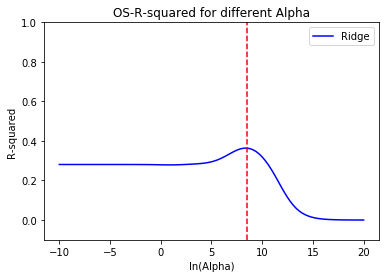

Optimal alpha for Ridge=4840.863945165378, best OS R_2=0.3638277322617045


In [62]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,REsample1_311.iloc[:,3:],REsample1_311.sale_price,REsample3_311.iloc[:,3:],REsample3_311.sale_price,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635642910423.2, tolerance: 566321910152.5012
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635398620435.0, tolerance: 566321910152.5012
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635067862692.8, tolerance: 566321910152.5012
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156563462

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1554442120033098.5, tolerance: 566321910152.5012
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1550495642486593.8, tolerance: 566321910152.5012
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1545165061219025.8, tolerance: 566321910152.5012
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153797024

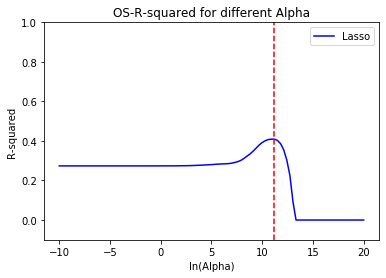

Optimal alpha for Lasso=74022.2655041914, best OS R_2=0.4090969394053081


In [63]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,REsample1_311.iloc[:,3:],REsample1_311.sale_price,REsample3_311.iloc[:,3:],REsample3_311.sale_price,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

#### Task 2. Model Mean income of the zip code population using 311 profile of the neighborhood

In [64]:
#load the data
dataIncome=pd.read_csv(folder+"data/MeanZip.csv",index_col=0)
dataIncome=dataIncome.apply(pd.to_numeric, errors='coerce')
dataIncome=dataIncome.loc[dataIncome.Mean>0]
dataIncome.head()

,Median,Mean,Pop
Zip,,,
1001,56662.5735,66687.7509,16445
1002,49853.4177,75062.6343,28069
1003,28462.0000,35121.0000,8491
1005,75423.0000,82442.0000,4798
1007,79076.3540,85801.9750,12962


In [65]:
dataIncome_311 = pd.merge(dataIncome, data311, left_index = True, right_index = True, how = 'inner')
dataIncome_311.head()

,Median,Mean,Pop,F1,F2,F3,F4,F5,F6,F7,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
Zip,,,,,,,,,,,,,,,,,,,,,
10001.0,71244.6100,123112.7764,17678,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,30843.9574,46258.6118,70878,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,89998.5339,139330.9968,53609,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,110183.6857,156682.7615,1271,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0
10005.0,115133.2855,163762.6601,1517,0.000000,0.000000,0.008219,0.0,0.000000,0.002192,0.000548,...,0.000000,0.000000,0.000000,0.013699,0.000000,0.000548,0.000000,0.019726,0.0,0.0


In [66]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(dataIncome_311))
dataIncome1_311=dataIncome_311.loc[splitind<=0.4]
dataIncome2_311=dataIncome_311.loc[(splitind>0.4)&(splitind<0.7)]
dataIncome3_311=dataIncome_311.loc[(splitind>=0.7)]

#### Q1. Perform regularied regression of Mean income of the zip code vs its 311 profile 
Train Ridge and Lasso over dataIncome1 with an arbitrary default parameter $\alpha=100$.
Then evaluate their out-of-sample performance over dataIncome3
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [67]:
dataIncome1_311.head()

,Median,Mean,Pop,F1,F2,F3,F4,F5,F6,F7,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
Zip,,,,,,,,,,,,,,,,,,,,,
10002.0,30843.9574,46258.6118,70878,0.001330,0.000000,0.007095,0.0,0.0,0.001862,0.001596,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10004.0,110183.6857,156682.7615,1271,0.000000,0.000000,0.009740,0.0,0.0,0.002597,0.001948,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0
10011.0,92359.4888,160936.5432,45899,0.001200,0.000100,0.015000,0.0,0.0,0.001100,0.003300,...,0.000900,0.000800,0.000000,0.005100,0.003200,0.000600,0.001200,0.032800,0.0,0.0
10016.0,96760.4462,144872.3901,49904,0.001143,0.000104,0.010907,0.0,0.0,0.000208,0.002597,...,0.000312,0.000208,0.000208,0.022021,0.000519,0.000727,0.000831,0.030851,0.0,0.0
10017.0,102523.5025,149723.7834,16231,0.000227,0.000000,0.010658,0.0,0.0,0.000227,0.003855,...,0.000227,0.000227,0.000000,0.010658,0.000454,0.001814,0.000227,0.050794,0.0,0.0


In [68]:
mu=dataIncome1_311.iloc[:,3:].mean()
sigma=dataIncome1_311.iloc[:,3:].std()

In [69]:
dataIncome1_311.iloc[:,3:]=(dataIncome1_311.iloc[:,3:]-mu)/sigma
dataIncome2_311.iloc[:,3:]=(dataIncome2_311.iloc[:,3:]-mu)/sigma
dataIncome3_311.iloc[:,3:]=(dataIncome3_311.iloc[:,3:]-mu)/sigma

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [70]:
dataIncome1_311 = dataIncome1_311.replace([np.inf, -np.inf, np.nan], 0)

In [71]:
dataIncome2_311 = dataIncome2_311.replace([np.inf, -np.inf, np.nan], 0)

In [72]:
dataIncome3_311 = dataIncome3_311.replace([np.inf, -np.inf, np.nan], 0)

In [73]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=100)
Ridge.fit(dataIncome1_311.iloc[:,3:],dataIncome1_311.Mean)
# In sample:
MeanPricePredRidge_IS=Ridge.predict(dataIncome1_311.iloc[:,3:])
print("The IS R-squared of Ridge is: {}".format(r2_score(dataIncome1_311.Mean,MeanPricePredRidge_IS)))
Ridge.coef_

The IS R-squared of Ridge is: 0.9140964381368712


array([-1.08296657e+03, -4.03698865e+02,  1.75984460e+03, -1.39005672e+03,
       -4.20094605e+00,  9.30814105e+02,  2.22486714e+03,  3.38588377e+02,
        1.38456897e+00,  7.23964852e+02, -7.45107561e+02, -1.50837899e+03,
        5.67901190e+02, -4.91939146e+01,  4.57842780e+02,  2.71103328e+03,
       -9.26588786e+02,  6.18588035e+02, -6.33624406e+02, -3.93879255e+02,
        1.06298881e+03,  1.31605580e+03, -6.36497514e+02,  6.26764666e+02,
       -6.93563501e+02, -3.27861633e+02, -1.08984153e+02, -7.18819859e+02,
        2.01249192e+03, -9.08012699e+02,  5.75935239e+02,  5.79006329e+02,
        1.02483470e+03, -2.29983589e+02, -6.19588154e+02,  3.04316402e+02,
       -4.87275704e+02, -2.15831807e+03,  7.49194875e+02,  1.26525535e+02,
       -5.77103033e+02,  1.25268181e+02, -1.51742707e+03, -4.64947536e+01,
        6.69427565e+02,  3.02344434e+02,  4.10421412e+01,  6.92873888e+02,
       -1.30475453e+03,  1.66261869e+02,  1.17011130e+03,  7.47084017e+02,
        1.30063888e+01,  

In [74]:
MeanPricePredRidge_OS=Ridge.predict(dataIncome3_311.iloc[:,3:])
print("The OS R-squared of Ridge is: {0}".format(r2_score(dataIncome3_311.Mean,MeanPricePredRidge_OS)))

The OS R-squared of Ridge is: 0.5165160494282188


In [75]:
#try Lasso with an another arbitrary regularization parameter alpha=0.01 (if we try alpha=1 this turns out to be too much regularization already)
Lasso=linear_model.Lasso(fit_intercept=True, alpha=100)

Lasso.fit(dataIncome1_311.iloc[:,3:],dataIncome1_311.Mean)
# In sample:
MeanPricePredLasso_IS=Lasso.predict(dataIncome1_311.iloc[:,3:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(dataIncome1_311.Mean,MeanPricePredLasso_IS)))
#Out of sample
MeanPricePredLasso_OS=Lasso.predict(dataIncome3_311.iloc[:,3:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(dataIncome3_311.Mean,MeanPricePredLasso_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.9986796079153523
The OS R-squared of Lasso is: -0.4851194159949941


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57446573.40069085, tolerance: 12626796.94567336
  positive)


array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.40889863e+03,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -1.06565515e+03,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -8.08943685e+02,  0.00000000e+00,  0.00000000e+00,  2.33394423e+01,
       -4.21127918e+03,  3.50267192e+03,  0.00000000e+00,  0.00000000e+00,
        3.80942985e+03,  6.59557297e+02, -8.73466249e+02,  1.23332831e+02,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.20264558e+03,  3.34323758e+02,  0.00000000e+00,
        3.49231666e+03,  0.00000000e+00,  9.63954125e+02,  1.14340235e+02,
       -0.00000000e+00, -0.00000000e+00,  8.95147460e+02, -0.00000000e+00,
       -6.04185921e+03, -0.00000000e+00, -2.07349981e+03,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.07730654e+04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  

#### Q2. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range -exp(10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set. 

Why do you think performance does not look that good, especially for one of the models?

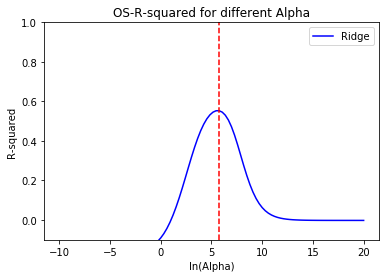

Optimal alpha for Ridge=316.57993140287226, best OS R_2=0.5529653922106624


In [76]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,dataIncome1_311.iloc[:,3:],dataIncome1_311.Mean,dataIncome3_311.iloc[:,3:],dataIncome3_311.Mean,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13796828.320802163, tolerance: 12626796.94567336
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18601334.421607535, tolerance: 12626796.94567336
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22114339.41478085, tolerance: 12626796.94567336
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29238571.8

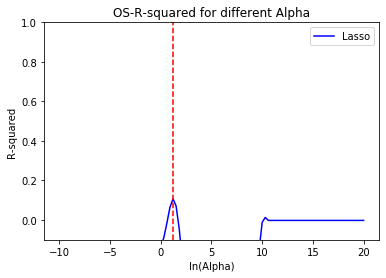

Optimal alpha for Lasso=3.360605654750301, best OS R_2=0.1074095203590979


In [77]:
(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,dataIncome1_311.iloc[:,3:],dataIncome1_311.Mean,dataIncome3_311.iloc[:,3:],dataIncome3_311.Mean,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

The performance does not look good over the Lasso model and this is because all the variables are important in this case, so we don't necessarily want to get rid of them, we'd just rather shrink their coefficient as in Ridge. Ridge is better served when there is a large number of variables, each with a small effect.